In [2]:
import sys
import os

project_root = '/home/20230765/src'
if project_root not in sys.path:
    sys.path.append(project_root)


In [3]:
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from redi.pipeline_re_sd import ReSDPipeline
import torch
import json
from redi.trajectory import generate_trajectory, save_trajectory, retrieve_nearest_neigbours, generate_trajectory_from_latents
from redi.knowledge_base import create_kb, clean_kb
import h5py
import numpy as np
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import faiss

In [ ]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    variant="fp16")


json_path = "../data/generated_data/prompts/raw_prompts.json"
with open(json_path, "r") as f:
    prompts = json.load(f)

for prompt in tqdm(prompts):
    torch.cuda.empty_cache()
    generation = generate_trajectory(
        prompt=prompt,
        pipeline=pipe,
        device="cuda",
        num_inference_steps=30,
        scheduler=DDIMScheduler
    )
    save_trajectory(
        trajectory=generation[0],
        prompt=generation[1],
        trajectory_filename="../data/generated_data/raw_trajectories",
        prompt_filename="../data/generated_data/raw_prompts",
    )
    del generation

- Ideas to explore - how different are the neigbours with decreasing PCA size
- How differnt are the neighbours if we move key value
- How different are the neighbours if we create more detailed combined keys (like combination of multiple trajectory steps)
- How the quality of generation is affected by the size of KB (if I can have some better size KB)
- Experiment with different schedulers, models (before KB generation)
- Idea of training intermediate model f(key, nearest_neigbours_keys, value) = true value

In [3]:
pipe = ReSDPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

#### Reference KB

In [70]:
key_margin_steps=0
value_margin_steps=20

trajectory_path="../data/generated_data/trajectories.h5"
kb_path="../data/reference_knowledge_base/knowledge_base.h5"
faiss_index_path="../data/reference_knowledge_base/faiss_index.bin"

prompts_from_path="../data/generated_data/prompts.jsonl"
prompts_to_path="../data/reference_knowledge_base/prompts.json"

key_compression = None
compression_path="../data/reference_knowledge_base/compression.pkl"
embedding_dim=1

In [ ]:
clean_kb(
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_path=prompts_to_path,
        compression_path=compression_path,
    )

In [40]:
create_kb(
    key_margin_steps=key_margin_steps,
    value_margin_steps=value_margin_steps,
    trajectory_path=trajectory_path,
    kb_path=kb_path,
    faiss_index_path=faiss_index_path,
    prompts_from_path=prompts_from_path,
    prompts_to_path=prompts_to_path,
    key_compression=key_compression,
    compression_path=compression_path,
    embedding_dim=embedding_dim
)

2000it [04:36,  7.24it/s]


In [75]:
np.random.seed(42)
query_set = np.random.choice(
    np.arange(0, 2000), size=200, replace=False
)
key_set = list(set(np.arange(0, 2000)) - set(query_set))
embedding_dims = [2, 4, 8, 16, 32, 64, 128, 256, 512]
prompts = json.load(open(prompts_to_path, "r"))

with h5py.File(trajectory_path, "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())
    reference_neighbours_list = []
    for query in tqdm(query_set):
        # print(query, prompts[str(query)])
        query = trajectory_file[traj_names[query]][key_margin_steps]
        neighbours = retrieve_nearest_neigbours(
            query_array=query,
            num_neighbours=11,
            index_path=faiss_index_path,
            kb_path=kb_path
        )
        # for neighbour in neighbours:
        #     print(neighbour[2], prompts[neighbour[2]], np.round(neighbour[1],3))
        # print("\n\n")
        
        reference_neighbours_list.append([int(neighbour[2]) for neighbour in neighbours][1:])

  0%|          | 0/200 [00:00<?, ?it/s]

#### KB testing

In [76]:
key_margin_steps=0
value_margin_steps=20

trajectory_path="../data/generated_data/trajectories.h5"
kb_path="../data/knowledge_base/knowledge_base.h5"
faiss_index_path="../data/knowledge_base/faiss_index.bin"

prompts_from_path="../data/generated_data/prompts.jsonl"
prompts_to_path="../data/knowledge_base/prompts.json"

key_compression = "pca"
compression_path="../data/knowledge_base/compression.pkl"
embedding_dim=1

In [79]:
dim_neighbours = []
for i in tqdm(embedding_dims):
    create_kb(
        key_margin_steps=key_margin_steps,
        value_margin_steps=value_margin_steps,
        trajectory_path=trajectory_path,
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_from_path=prompts_from_path,
        prompts_to_path=prompts_to_path,
        key_compression=key_compression,
        compression_path=compression_path,
        embedding_dim=i
    )
    # clean queries
    with h5py.File(kb_path, "a") as kb_file:
        for query in query_set:
            del kb_file[str(query)]
            
    #remove ids
    index = faiss.read_index(faiss_index_path)
    index.remove_ids(query_set)
    faiss.write_index(index, faiss_index_path)
    
    
    
    # find neigbours
    neighbours_list = []
    with h5py.File(trajectory_path, "r") as trajectory_file:
        traj_names = list(trajectory_file.keys())
        for query in tqdm(query_set):
            query = trajectory_file[traj_names[query]][key_margin_steps]
            if key_compression is not None:
                pca = pickle.load(open(compression_path, "rb"))
                query = pca.transform(query.reshape(1, -1)).squeeze()
            neighbours = retrieve_nearest_neigbours(
                query_array=query,
                num_neighbours=10,
                index_path=faiss_index_path,
                kb_path=kb_path
            )
            neighbours_list.append([int(neighbour[2]) for neighbour in neighbours])
    dim_neighbours.append(neighbours_list)
    
    clean_kb(
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_path=prompts_to_path,
        compression_path=compression_path,
    )


  0%|          | 0/9 [00:00<?, ?it/s]

2000it [00:02, 838.03it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


2000it [00:02, 817.20it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


2000it [00:02, 761.61it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


2000it [00:03, 628.43it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


2000it [00:03, 538.66it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


2000it [00:05, 343.83it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


2000it [00:10, 186.77it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


2000it [00:19, 103.02it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


2000it [00:25, 78.00it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


In [80]:
dim_neighbours.append(reference_neighbours_list)

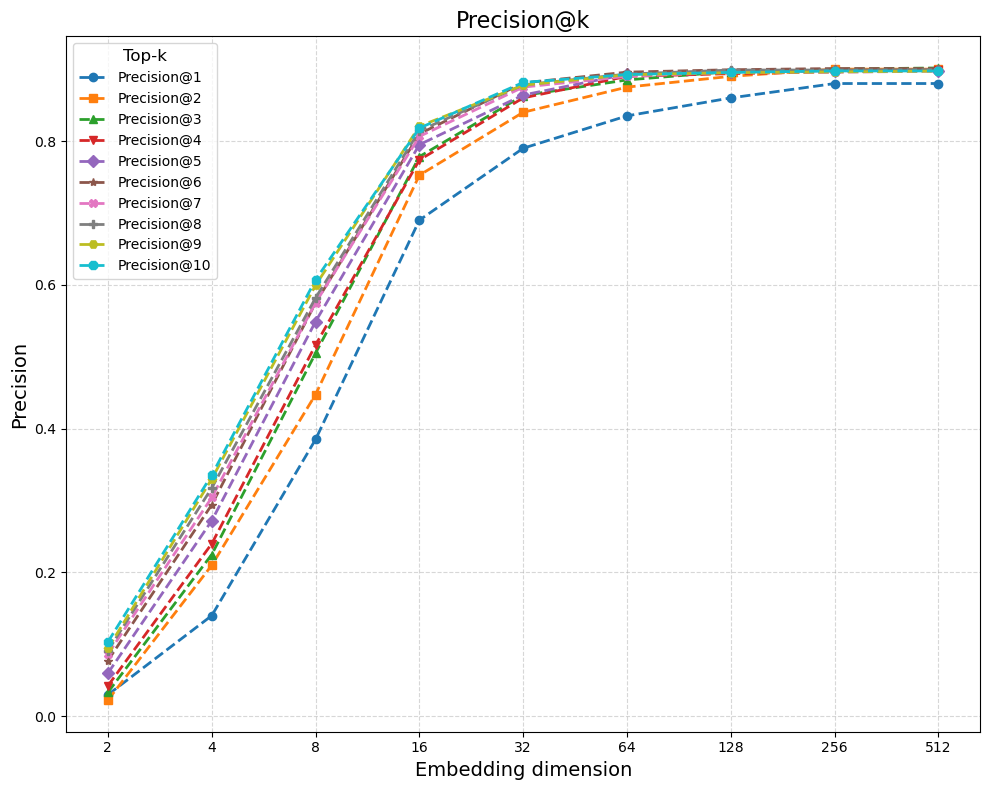


Precision Table:
     Precision@1  Precision@2  Precision@3  Precision@4  Precision@5  \
2          0.030       0.0225       0.0333       0.0425        0.060   
4          0.140       0.2100       0.2250       0.2400        0.272   
8          0.385       0.4475       0.5050       0.5162        0.549   
16         0.690       0.7525       0.7783       0.7738        0.795   
32         0.790       0.8400       0.8633       0.8600        0.864   
64         0.835       0.8750       0.8850       0.8900        0.893   
128        0.860       0.8900       0.8967       0.8938        0.896   
256        0.880       0.9000       0.9000       0.8962        0.898   
512        0.880       0.9000       0.9017       0.8988        0.898   

     Precision@6  Precision@7  Precision@8  Precision@9  Precision@10  
2         0.0775       0.0864       0.0912       0.0944        0.1035  
4         0.2942       0.3043       0.3175       0.3300        0.3355  
8         0.5750       0.5750       0.5819   

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create structures
plt.figure(figsize=(10, 8))
markers = ['o', 's', '^', 'v', 'D', '*', 'X', 'P', 'H', '8']

precision_table = {}  # Dictionary to build the table

for k in range(1, 11):
    precision_at_k = np.zeros(len(dim_neighbours)-1)
    for i in range(len(query_set)):
        neighbours_comparison = [dim[i] for dim in dim_neighbours]
        for j in range(len(neighbours_comparison)-1):
            precision_at_k[j] += len(set(neighbours_comparison[j][:k]) & set(neighbours_comparison[-1][:k])) / k

    precision_values = precision_at_k / len(query_set)

    # Store in dictionary for table
    precision_table[f"Precision@{k}"] = precision_values

    # Plot
    plt.plot(
        [str(i) for i in embedding_dims],
        precision_values,
        marker=markers[k-1],
        linestyle='--',
        linewidth=2,
        label=f"Precision@{k}"
    )

# Plot settings
plt.title("Precision@k", fontsize=16)
plt.xlabel("Embedding dimension", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Top-k", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

# ----- Table Part -----
# Build DataFrame
precision_df = pd.DataFrame(precision_table, index=[str(i) for i in embedding_dims])

# Print nicely
print("\nPrecision Table:")
print(precision_df.round(4))  # rounding for clean display



In [ ]:
precision_df = pd.DataFrame(precision_table, index=[str(i) for i in embedding_dims])

# Print nicely
print("\nPrecision Table:")
print(precision_df.round(4))

In [ ]:
with h5py.File(trajectory_path, "r") as trajectory_file:
        traj_names = list(trajectory_file.keys())
        for query in query_set:
            query = trajectory_file[traj_names[query]][key_margin_steps]
            if key_compression is not None:
                pca = pickle.load(open(compression_path, "rb"))
                query = pca.transform(query.reshape(1, -1)).squeeze()
            neighbours = retrieve_nearest_neigbours(
                query_array=query,
                num_neighbours=10,
                index_path=faiss_index_path,
                kb_path=kb_path
            )
        query = trajectory_file[traj_names[1800]][key_margin_steps]
        if key_compression is not None:
            pca = pickle.load(open(compression_path, "rb"))
            query = pca.transform(query.reshape(1, -1)).squeeze()
        neighbours = retrieve_nearest_neigbours(
            query_array=query,
            num_neighbours=10,
            index_path=faiss_index_path,
            kb_path=kb_path
        )

prompts = json.load(open(prompts_to_path, "r"))
for neighbour in neighbours:
    print(prompts[neighbour[2]], np.round(neighbour[1],3))


In [116]:
prompt = prompts[neighbours[0][2]]
latent = (neighbours[1][0] + neighbours[2][0] + neighbours[3][0] + neighbours[4][0] + neighbours[5][0] + neighbours[6][0] + neighbours[7][0] + neighbours[8][0] + neighbours[9][0]) / 9

In [94]:
neighbour_num = 1
latent = neighbours[neighbour_num][0]

In [75]:
value_margin_steps

15

  0%|          | 0/30 [00:00<?, ?it/s]

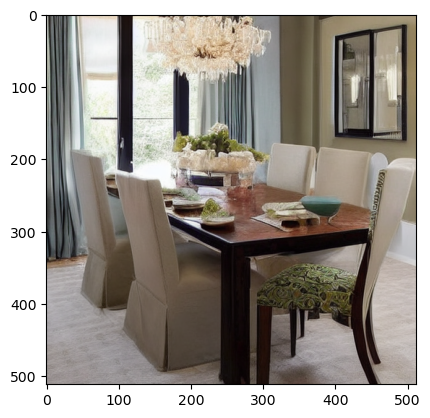

In [117]:
img = generate_trajectory_from_latents(
    prompt=prompts[neighbours[0][2]],
    latent=latent,
    device="cuda",
    num_inference_steps=30,
    value_margin_steps=value_margin_steps,
    scheduler=DDIMScheduler,
    pipeline=pipe
)
plt.imshow(img)

  0%|          | 0/20 [00:00<?, ?it/s]

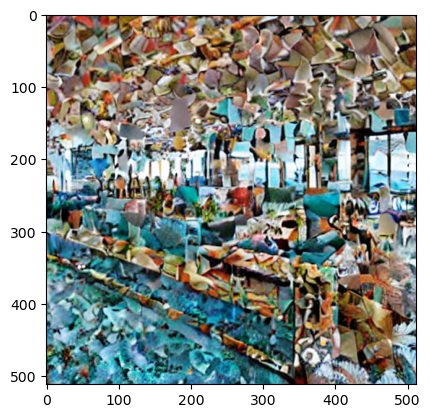

In [98]:
img = generate_trajectory_from_latents(
    prompt=prompts[neighbours[0][2]],
    latent=latent,
    device="cuda",
    num_inference_steps=30-10,
    value_margin_steps=value_margin_steps-10,
    scheduler=DDIMScheduler,
    pipeline=pipe
)
plt.imshow(img)

  0%|          | 0/2 [00:00<?, ?it/s]

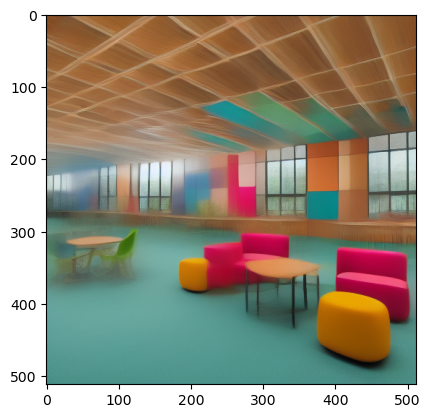

In [ ]:
# real
latent = neighbours[0][0] 

img = generate_trajectory_from_latents(
    prompt=prompt,
    latent=latent,
    device="cuda",
    num_inference_steps=20,
    value_margin_steps=20,
    scheduler=DDIMScheduler,
    pipeline=pipe
)

plt.imshow(img)